In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from IPython.display import Audio, display

import torch
import torch.nn as nn
from torch.nn import init
import torchaudio
import math, random
from torchaudio import transforms
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn.functional as F

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from torchsummary import summary
from matplotlib import cm
import matplotlib as mpl


In [2]:
dataset='C:/Users/Eman Badr/Downloads/data/GroundType1/'

ID=[]
label=[]
ClassID=[]
 
# iterate over files in that directory

for folder in os.listdir(dataset):                               #go into the directory
    for filename in os.listdir(dataset+ str(folder)):          #go in every class 
        f = os.path.join(dataset+ str(folder), filename) #scan through every file in that class
        if os.path.isfile(f):
            ID.append(f.split('\\')[-1])
            label.append(str(folder))
            
for i in range(len(label)):
    if(label[i]=='Concrete'):
        ClassID.append(0) 
    elif(label[i]=='Flatmountain'):
        ClassID.append(1)
    else:
        ClassID.append(2)


In [3]:
dset=pd.DataFrame()
dset['ID']=ID
dset['label']=label
dset['ClassID']=ClassID


In [4]:
dset.head(599)

,ID,label,ClassID
0,Concrete-01.wav,Concrete,0
1,Concrete-02.wav,Concrete,0
2,Concrete-03.wav,Concrete,0
3,Concrete-04.wav,Concrete,0
4,Concrete-05.wav,Concrete,0
...,...,...,...
594,Grass-94.wav,Grass,2
595,Grass-95.wav,Grass,2
596,Grass-96.wav,Grass,2
597,Grass-97.wav,Grass,2


In [5]:
dset.to_csv('C:/Users/Eman Badr/Downloads/data/data.csv')

In [6]:
df = pd.read_csv('C:/Users/Eman Badr/Downloads/data/data.csv')

In [7]:
df['ID'].loc[150]

'Concrete-50.wav'

In [8]:
Grass = 'C:/Users/Eman Badr/Downloads/data/GroundType1/Grass/'
path=os.path.join(Grass, df['ID'].loc[595])
print(path)

C:/Users/Eman Badr/Downloads/data/GroundType1/Grass/Grass-95.wav


Shape of waveform: torch.Size([1, 156000])
Sample rate of waveform: 48000
(tensor([[-9.5856e-02, -8.4930e-02, -7.0007e-02,  ...,  6.1035e-05,
          1.3672e-02,  2.6642e-02]]), 48000)


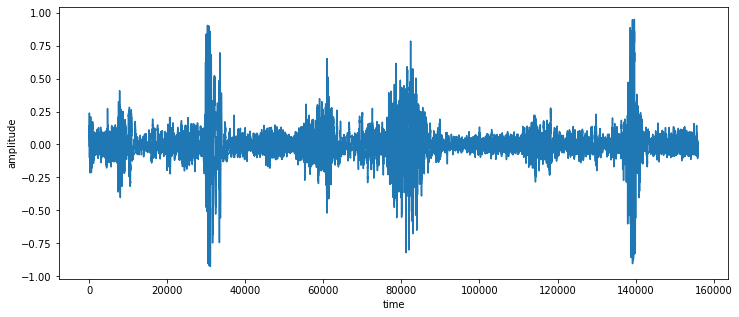

In [9]:
def plot_audio(filename):
    waveform, sample_rate = torchaudio.load(filename)

    print("Shape of waveform: {}".format(waveform.size()))
    print("Sample rate of waveform: {}".format(sample_rate))

    fig1, ax1 = plt.subplots(figsize=(12, 5))    
  
    ax1.plot(waveform[0,:].numpy())

    ax1.set_xlabel('time') 
    ax1.set_ylabel("amplitude")

    return waveform, sample_rate


aud= plot_audio(path)
print(aud)

Shape of spec: torch.Size([1, 64, 305])
Shape of spec: torch.Size([1, 64, 305])


tensor([[[ 25.5493,  21.3841,  22.3438,  ...,  -3.5486,  12.9258,  15.9601],
         [ 27.8234,  25.0760,  25.8150,  ...,   3.6385,  11.6593,  20.3916],
         [ 24.6822,  27.2284,  24.1783,  ...,  11.5164,  10.3024,  18.8846],
         ...,
         [-31.9133, -36.2757, -35.0923,  ..., -36.1378, -36.3619, -35.0219],
         [-29.8891, -35.5567, -35.3948,  ..., -33.3156, -36.0309, -33.8310],
         [-29.4297, -34.2287, -34.1284,  ..., -34.9304, -34.0786, -34.0415]]])

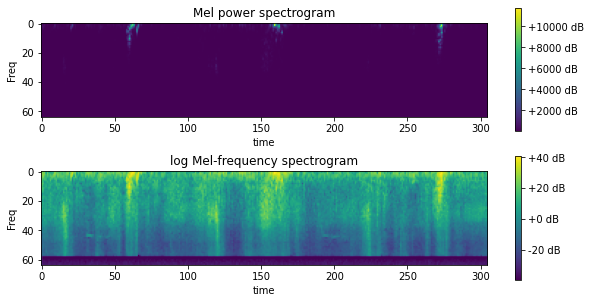

In [10]:
def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
    sig, sr = aud
    top_db = 80
    
    # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
    spec1 = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

    # Convert to decibels
    spec = transforms.AmplitudeToDB(top_db=top_db)(spec1)
    
    
    print("Shape of spec: {}".format(spec1.size()))
    print("Shape of spec: {}".format(spec.size()))
     
    fig, ax = plt.subplots(nrows=2, ncols=1, sharey=True,  figsize=(10, 5))
   
    
    s= ax[0].imshow(spec1[0,:,:].numpy())
    s1= ax[1].imshow(spec[0,:,:].numpy())
    ax[0].grid(False)
    ax[1].grid(False)
    fig.colorbar(s, ax=ax[0], format='%+2.0f dB') 
    fig.colorbar(s1, ax=ax[1], format='%+2.0f dB')    
    ax[0].set_title('Mel power spectrogram') 
    ax[0].set_xlabel('time') 
    ax[0].set_ylabel("Freq")
    
    ax[1].set_title('log Mel-frequency spectrogram')
    ax[1].set_xlabel('time') 
    ax[1].set_ylabel("Freq")


    return (spec)


spectro_gram(aud)

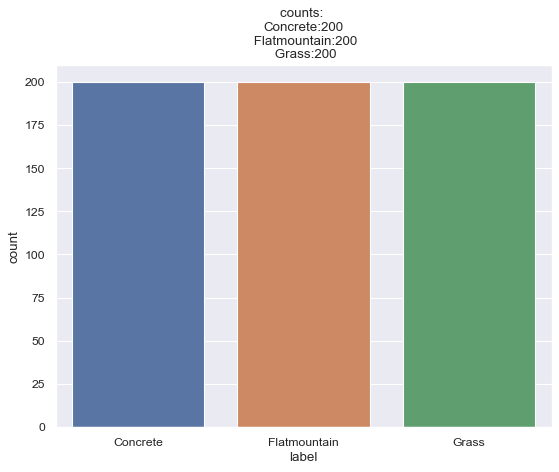

In [11]:
plt.figure(figsize=(8,6),dpi=80)
sn.set_theme(style="darkgrid")
sn.countplot(x ='label',data=dset)
plt.title('counts: \n' +'Concrete:'+str(dset.label.value_counts()[0])+'\n Flatmountain:'+str(dset.label.value_counts()[1])+'\n Grass:'+str(dset.label.value_counts()[2]))
plt.show()

In [12]:
print(dset.label.unique())

['Concrete' 'Flatmountain' 'Grass']


In [13]:
print("Number of training examples=", dset.shape[0], "  Number of classes=", len(dset.label.unique()))

Number of training examples= 600   Number of classes= 3


In [14]:
# Read file

df['ID'] = df['label'].astype(str) + '/' + df['ID'].astype(str)
# Take relevant columns
df = df[['ID', 'ClassID']]
df.head(350)

,ID,ClassID
0,Concrete/Concrete-01.wav,0
1,Concrete/Concrete-02.wav,0
2,Concrete/Concrete-03.wav,0
3,Concrete/Concrete-04.wav,0
4,Concrete/Concrete-05.wav,0
...,...,...
345,Flatmountain/Flat mountain road-45.wav,1
346,Flatmountain/Flat mountain road-46.wav,1
347,Flatmountain/Flat mountain road-47.wav,1
348,Flatmountain/Flat mountain road-48.wav,1


In [15]:
class AudioUtil():
    def open(audio_file): # Load an audio file. Return the signal as a tensor and the sample rate
        sig, sr = torchaudio.load(audio_file)
        return (sig, sr)
    
    
    def resample(aud, newsr):
        sig, sr = aud
  
        if (sr == newsr):# Nothing to do
            #print('newsr',newsr)
            return aud

        num_channels = sig.shape[0]# Resample first channel
        #print('num_channels',num_channels)
        resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
        #print("Shape of transformed waveform: {}".format(resig.size()))

        #plt.figure()
        #plt.plot(resig[0,:].numpy())
        #print('resig',resig)
        #print('resig',resig.shape)

        return (resig, newsr)
    
    

    def pad_trunc(aud, max_ms):
        sig, sr = aud
        #print('sig',sig)
        #print('sr',sr)
        #print(sig.shape)
        num_rows, sig_len = sig.shape
        #print('num_rows',num_rows)
        #print('sig_len',sig_len)
        max_len = sr//1000 * max_ms
        #print('max_len',max_len)

        if (sig_len > max_len): # Truncate the signal to the given length
           sig = sig[:,:max_len]
           #print('sig_pad_trunc',sig.shape)
           #plt.figure()
           #plt.plot(sig[0,:].numpy())
         

        elif (sig_len < max_len): # Length of padding to add at the beginning and end of the signal
              pad_begin_len = random.randint(0, max_len - sig_len)
              #print('pad_begin_len',pad_begin_len)
              pad_end_len = max_len - sig_len - pad_begin_len
              #print('pad_end_len',pad_end_len)
              # Pad with 0s
              pad_begin = torch.zeros((num_rows, pad_begin_len))
              #print('pad_begin',pad_begin)
              pad_end = torch.zeros((num_rows, pad_end_len))
              sig = torch.cat((pad_begin, sig, pad_end),1) 
              #print('sig_pad_trunc', sig.shape)
              #plt.figure()
              #sig1=sig[0,:].numpy()
              #plt.plot(sig1)      
                                     
        return (sig, sr)          
                                      

    def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
        sig, sr = aud
        top_db = 80
    
        # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
        spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

        # Convert to decibels
        spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
        
        #print("Shape of spec: {}".format(spec.size()))
        return (spec)
    
        #def play_audio(waveform, sample_rate):
        #display(Audio(waveform[0], rate=sample_rate))
        
        


In [16]:
 #dataset=[]
# ----------------------------
# Sound Dataset
# ----------------------------
class SoundDS(Dataset):
    def __init__(self, df, data_path):
        self.df = df
        self.data_path = str(data_path)
        self.duration = 4000
        self.sr = 48000
        dataset=[]  
        # ----------------------------
        # Number of items in dataset
        # ----------------------------
    def __len__(self):
        return len(self.df)    
    
       # ----------------------------
       # Get i'th item in dataset
       # ----------------------------
    def __getitem__(self, idx):
       # Absolute file path of the audio file - concatenate the audio directory with the relative path
       audio_file = self.data_path + self.df.loc[idx, 'ID']
       #print(audio_file)

       class_id = self.df.loc[idx, 'ClassID']
        
       ID = self.df.loc[idx, 'ID']

       aud = AudioUtil.open(audio_file)

       reaud = AudioUtil.resample(aud, self.sr)

       dur_aud= AudioUtil.pad_trunc(reaud, self.duration)
       #print(dur_aud)
    
       sgram_features = AudioUtil.spectro_gram(dur_aud)
        
       #listen = AudioUtil.play_audio(dur_aud,self.sr)


       return  sgram_features, class_id

In [17]:
myds = SoundDS(df, dataset)
print(myds[20])

(tensor([[[-37.2823, -37.2823, -37.2823,  ..., -37.2823, -37.2823, -37.2823],
         [-37.2823, -37.2823, -37.2823,  ..., -37.2823, -37.2823, -37.2823],
         [-37.2823, -37.2823, -37.2823,  ..., -37.2823, -37.2823, -37.2823],
         ...,
         [-37.2823, -37.2823, -37.2823,  ..., -37.2823, -37.2823, -37.2823],
         [-37.2823, -37.2823, -37.2823,  ..., -37.2823, -37.2823, -37.2823],
         [-37.2823, -37.2823, -37.2823,  ..., -37.2823, -37.2823, -37.2823]]]), 0)


In [18]:
# data loader

random_seed = 64
torch.manual_seed(random_seed)
batch_size = 32

# Random split of 80:20 between training and validation
num_items = len(myds)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(myds, [num_train, num_val])
len(train_ds), len(val_ds)

# Create training and validation data loaders
train_loader = torch.utils.data.DataLoader(train_ds, batch_size= batch_size, shuffle=True)
print(len(train_loader))
test_loader = torch.utils.data.DataLoader(val_ds, batch_size= batch_size, shuffle=False)
print(len(test_loader))
#for i, batch in enumerate(train_loader):
   #print(i, batch)

15
4


In [19]:
examples = iter(train_loader)
data, targets= examples.next()
print(data.shape, targets.shape)
#print(' '.join(f'{classes[targets[j]]:5s}' for j in range(batch_size)))



#examples = iter(test_loader)
#example_data,example_targets= examples.next()
#print(example_data.shape, example_targets.shape)
#print(' '.join(f'{classes[example_targets[j]]:5s}' for j in range(batch_size)))

torch.Size([32, 1, 64, 376]) torch.Size([32])


In [20]:
# Audio Classification Model, Build the model architecture
# ----------------------------

class AudioClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        # first Convolution Block
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
        self.bn1 = nn.BatchNorm2d(16)
        self.drop1=nn.Dropout(0.25)
        init.kaiming_normal_(self.conv1.weight, mode='fan_out', nonlinearity='relu')
        self.conv1.bias.data.zero_()

        # Second Convolution Block
        self.conv2 = nn.Conv2d(16, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.bn2 = nn.BatchNorm2d(64)
        self.drop2=nn.Dropout(0.4)
        init.kaiming_normal_(self.conv2.weight, mode='fan_out', nonlinearity='relu')
        self.conv2.bias.data.zero_()
        
        #linear ouput
        self.ap = nn.AdaptiveMaxPool2d(output_size=1)# Input: (N, C, Hin, Win).Output: (N, C, S0, S1), where S=output_size.
        self.fc1 = nn.Linear(in_features=64, out_features=32)
        self.fc2 = nn.Linear(in_features=32, out_features=3)
 
    # ----------------------------
    # Forward pass computations
    # ----------------------------
    def forward(self, x):
        x = self.bn1(F.relu(self.conv1(x)))# Run the convolutional blocks
        x= self.drop1(x)
        x = self.bn2(F.relu(self.conv2(x)))
        x= self.drop2(x)
        x = self.ap(x)# Adaptive pool
        x = torch.flatten(x, 1) # flatten for input to linear layer
        x = F.relu(self.fc1(x))     # Linear layer
        x = self.fc2(x)
        return x            # Final output



In [21]:
#TRAINING THE NETWORK

num_epochs= 50


def train(model, train_loader, optimizer,scheduler):
        model.train()
        loss_total = 0
        correct_prediction = 0
        total_prediction = 0
        
        for i, data in enumerate(train_loader):
            #LOADING THE DATA IN A BATCH
            data, target = data[0], data[1]
            #target= target.float()pred = np.round(output)
            
            # clear the gradients
            optimizer.zero_grad()
            
            # Normalize the inputs
            inputs_m, inputs_s = data.mean(), data.std()
            data = (data - inputs_m) / inputs_s

        
            #FORWARD PASS
            output = model(data)
            loss = criterion(output, target) 
            
            #BACKWARD AND OPTIMIZE
            loss.backward()
            optimizer.step()
            scheduler.step()
        
            # calculating the total_loss for checking
            loss_total += loss.item()
        
        
            # Get the predicted class with the highest score
            _, prediction = torch.max(output,1)
            # Count of predictions that matched the target label
            correct_prediction += (prediction == target).sum().item()
            total_prediction += prediction.shape[0]
        
        
        
        # Print stats at the end of the epoch
        train_loss = loss_total /len(train_loader)
        acc = 100* correct_prediction/total_prediction
        print(f'Epoch: {epoch}, Loss: {train_loss:.2f}, Accuracy on training set is: {acc:.2f}')
        train_accu.append(acc)
        train_losses.append(train_loss)
        
        print('Finished Training') 
        
  

In [22]:
#TESTING THE MODE

def test(model, test_loader):
        y_true = []
        y_pred = []
        loss_total = 0
        correct_prediction = 0
        total_prediction = 0
        model.eval()
        
        with torch.no_grad():
             for i, data in enumerate(test_loader):
            
                #LOADING THE DATA IN A BATCH
                data, target = data[0], data[1]
                #target= target.float()
                
                # Normalize the inputs
                inputs_m, inputs_s = data.mean(), data.std()
                data = (data - inputs_m) / inputs_s
                       
                #FORWARD PASS
                output = model(data)
                loss = criterion(output, target)
            
                # calculating the total_loss for checking
                loss_total += loss.item() 
        
                # Get the predicted class with the highest score
                _, prediction = torch.max(output,1)
                y_pred.extend(prediction.tolist())
                y_true.extend(target.tolist()) 
                conf_matrix = confusion_matrix(y_true, y_pred)
                conf_matrix_df = pd.DataFrame(conf_matrix , index = ['Concrete','Flatmountain','Grass'], columns = ['Concrete','Flatmountain','Grass'])
                # Count of predictions that matched the target label
                correct_prediction += (prediction == target).sum().item()
                total_prediction += prediction.shape[0]
                
     
        # Print stats at the end of the epoch
        test_loss = loss_total /len(test_loader)
        acc = 100* correct_prediction/total_prediction
        print(f'Epoch: {epoch}, Loss: {test_loss:.2f}, Accuracy on testing set is: {acc:.2f}')
        test_accu.append(acc)
        test_losses.append(test_loss)
        
        
        plt.figure(figsize=(5,4))
        sn.heatmap(conf_matrix_df, annot=True , cmap="YlGnBu")
        plt.title('Confusion Matrix')
        plt.ylabel('Actal Values')
        plt.xlabel('Predicted Values')
        plt.show()
        



In [23]:
# Define the loss function and optimizer

model = AudioClassifier()
criterion = nn.CrossEntropyLoss()#this case is equivalent to the combination of LogSoftmax and NLLLoss.
optimizer = torch.optim.Adam(model.parameters(),lr=0.001, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                steps_per_epoch=int(len(train_loader)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')

In [24]:
summary(model, (1, 64, 376))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 33, 189]             272
       BatchNorm2d-2          [-1, 16, 33, 189]              32
           Dropout-3          [-1, 16, 33, 189]               0
            Conv2d-4           [-1, 64, 17, 95]           9,280
       BatchNorm2d-5           [-1, 64, 17, 95]             128
           Dropout-6           [-1, 64, 17, 95]               0
 AdaptiveMaxPool2d-7             [-1, 64, 1, 1]               0
            Linear-8                   [-1, 32]           2,080
            Linear-9                    [-1, 3]              99
Total params: 11,891
Trainable params: 11,891
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.09
Forward/backward pass size (MB): 4.65
Params size (MB): 0.05
Estimated Total Size (MB): 4.79
---------------------------------------------

Epoch: 0, Loss: 1.07, Accuracy on training set is: 44.58
Finished Training
Epoch: 0, Loss: 1.10, Accuracy on testing set is: 33.33


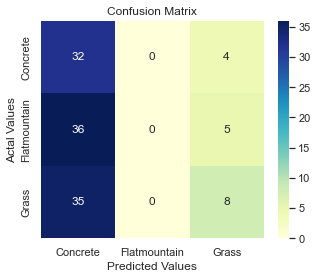

Epoch: 1, Loss: 1.00, Accuracy on training set is: 51.04
Finished Training
Epoch: 1, Loss: 1.05, Accuracy on testing set is: 55.00


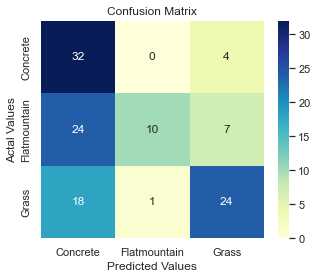

Epoch: 2, Loss: 0.91, Accuracy on training set is: 62.29
Finished Training
Epoch: 2, Loss: 0.98, Accuracy on testing set is: 65.00


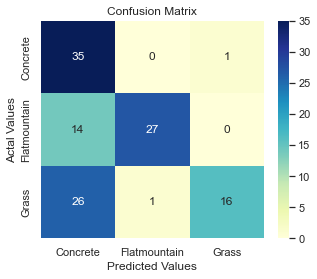

Epoch: 3, Loss: 0.84, Accuracy on training set is: 70.42
Finished Training
Epoch: 3, Loss: 0.90, Accuracy on testing set is: 74.17


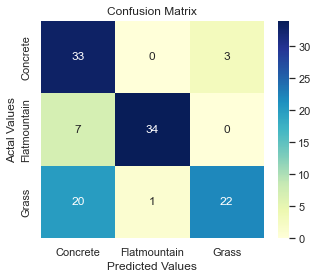

Epoch: 4, Loss: 0.71, Accuracy on training set is: 80.00
Finished Training
Epoch: 4, Loss: 0.81, Accuracy on testing set is: 84.17


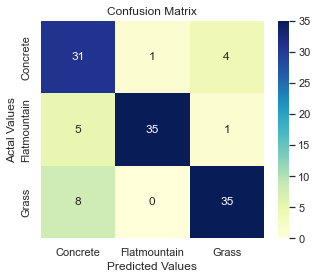

Epoch: 5, Loss: 0.63, Accuracy on training set is: 83.54
Finished Training
Epoch: 5, Loss: 0.74, Accuracy on testing set is: 81.67


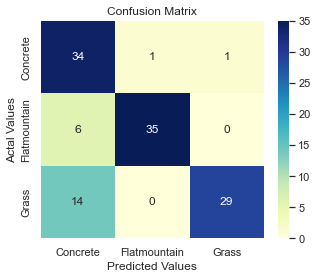

Epoch: 6, Loss: 0.52, Accuracy on training set is: 90.00
Finished Training
Epoch: 6, Loss: 0.66, Accuracy on testing set is: 90.00


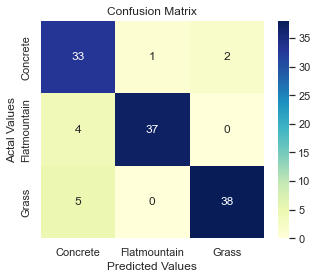

Epoch: 7, Loss: 0.44, Accuracy on training set is: 89.58
Finished Training
Epoch: 7, Loss: 0.58, Accuracy on testing set is: 86.67


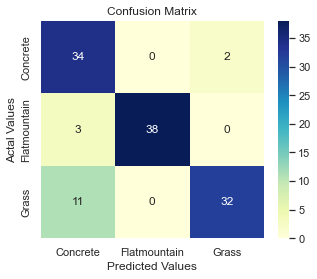

Epoch: 8, Loss: 0.36, Accuracy on training set is: 91.04
Finished Training
Epoch: 8, Loss: 0.51, Accuracy on testing set is: 90.83


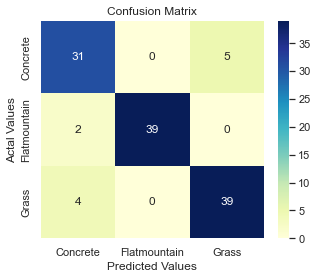

Epoch: 9, Loss: 0.28, Accuracy on training set is: 96.25
Finished Training
Epoch: 9, Loss: 0.48, Accuracy on testing set is: 87.50


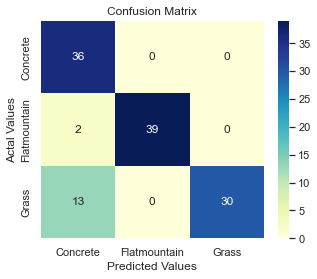

Epoch: 10, Loss: 0.24, Accuracy on training set is: 94.79
Finished Training
Epoch: 10, Loss: 0.39, Accuracy on testing set is: 93.33


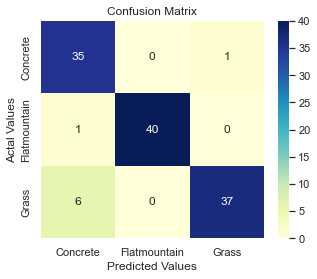

Epoch: 11, Loss: 0.21, Accuracy on training set is: 93.54
Finished Training
Epoch: 11, Loss: 0.35, Accuracy on testing set is: 94.17


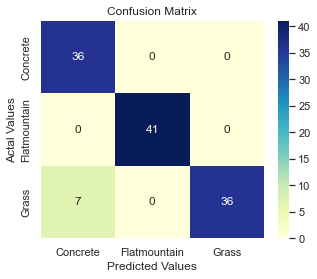

Epoch: 12, Loss: 0.15, Accuracy on training set is: 96.25
Finished Training
Epoch: 12, Loss: 0.35, Accuracy on testing set is: 87.50


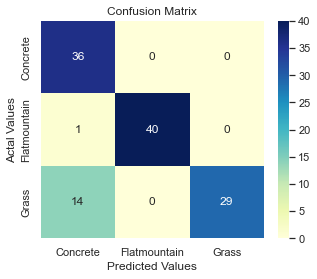

Epoch: 13, Loss: 0.13, Accuracy on training set is: 97.08
Finished Training
Epoch: 13, Loss: 0.29, Accuracy on testing set is: 92.50


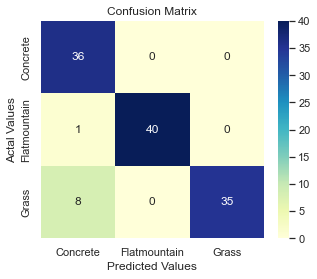

Epoch: 14, Loss: 0.09, Accuracy on training set is: 99.17
Finished Training
Epoch: 14, Loss: 0.23, Accuracy on testing set is: 97.50


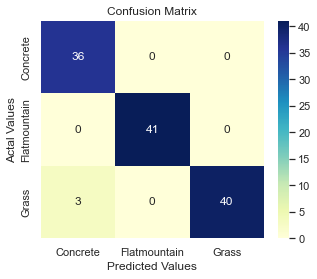

Epoch: 15, Loss: 0.10, Accuracy on training set is: 97.50
Finished Training
Epoch: 15, Loss: 0.39, Accuracy on testing set is: 78.33


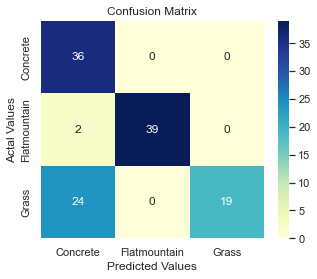

Epoch: 16, Loss: 0.07, Accuracy on training set is: 98.54
Finished Training
Epoch: 16, Loss: 0.19, Accuracy on testing set is: 95.00


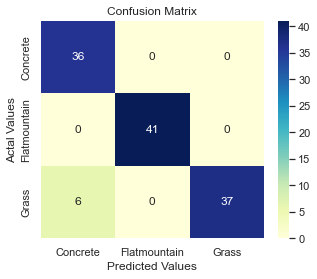

Epoch: 17, Loss: 0.07, Accuracy on training set is: 97.08
Finished Training
Epoch: 17, Loss: 0.20, Accuracy on testing set is: 96.67


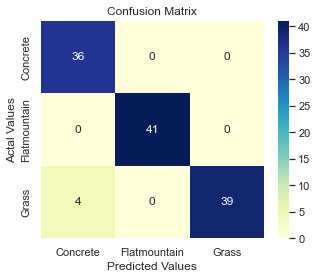

Epoch: 18, Loss: 0.06, Accuracy on training set is: 98.54
Finished Training
Epoch: 18, Loss: 0.19, Accuracy on testing set is: 95.00


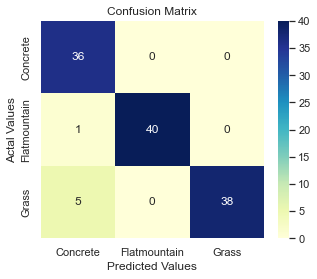

Epoch: 19, Loss: 0.04, Accuracy on training set is: 98.96
Finished Training
Epoch: 19, Loss: 0.24, Accuracy on testing set is: 91.67


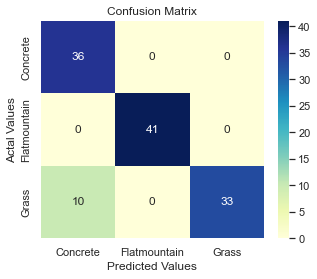

Epoch: 20, Loss: 0.05, Accuracy on training set is: 98.54
Finished Training
Epoch: 20, Loss: 0.17, Accuracy on testing set is: 95.00


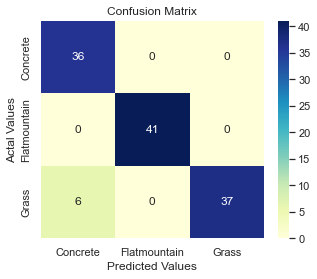

Epoch: 21, Loss: 0.06, Accuracy on training set is: 98.12
Finished Training
Epoch: 21, Loss: 0.11, Accuracy on testing set is: 99.17


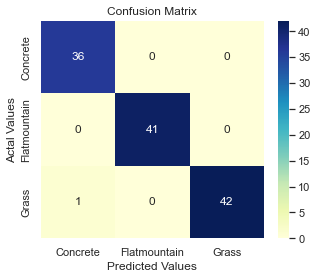

Epoch: 22, Loss: 0.05, Accuracy on training set is: 98.12
Finished Training
Epoch: 22, Loss: 0.13, Accuracy on testing set is: 99.17


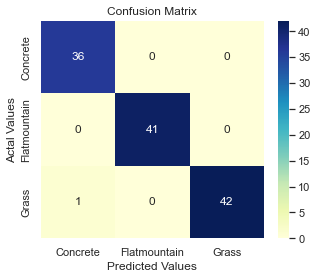

Epoch: 23, Loss: 0.05, Accuracy on training set is: 98.12
Finished Training
Epoch: 23, Loss: 0.19, Accuracy on testing set is: 95.00


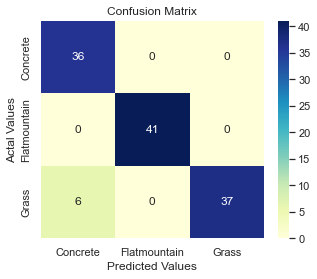

Epoch: 24, Loss: 0.03, Accuracy on training set is: 99.17
Finished Training
Epoch: 24, Loss: 0.15, Accuracy on testing set is: 95.83


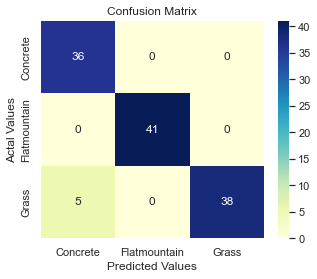

Epoch: 25, Loss: 0.05, Accuracy on training set is: 98.33
Finished Training
Epoch: 25, Loss: 0.23, Accuracy on testing set is: 90.00


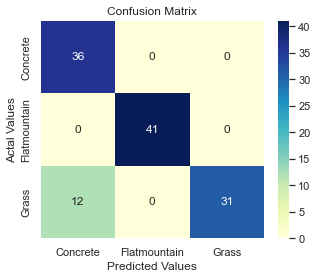

Epoch: 26, Loss: 0.04, Accuracy on training set is: 99.17
Finished Training
Epoch: 26, Loss: 0.17, Accuracy on testing set is: 95.00


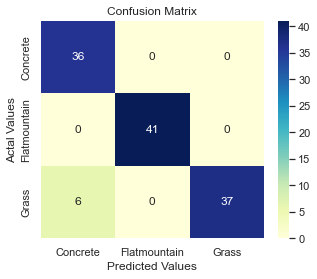

Epoch: 27, Loss: 0.04, Accuracy on training set is: 98.12
Finished Training
Epoch: 27, Loss: 0.18, Accuracy on testing set is: 95.00


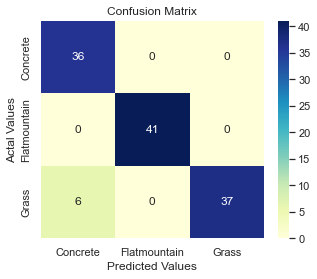

Epoch: 28, Loss: 0.02, Accuracy on training set is: 99.58
Finished Training
Epoch: 28, Loss: 0.15, Accuracy on testing set is: 95.00


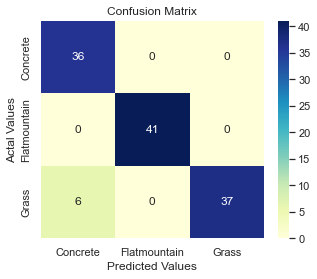

Epoch: 29, Loss: 0.03, Accuracy on training set is: 99.38
Finished Training
Epoch: 29, Loss: 0.23, Accuracy on testing set is: 89.17


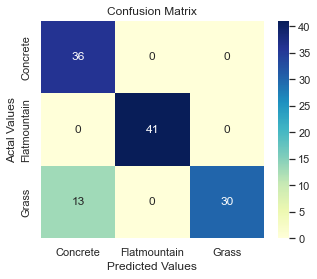

Epoch: 30, Loss: 0.05, Accuracy on training set is: 99.17
Finished Training
Epoch: 30, Loss: 0.11, Accuracy on testing set is: 96.67


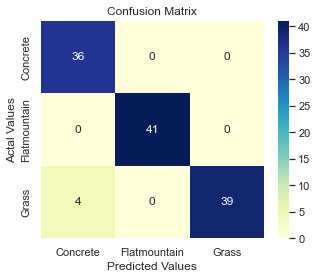

Epoch: 31, Loss: 0.03, Accuracy on training set is: 99.38
Finished Training
Epoch: 31, Loss: 0.14, Accuracy on testing set is: 95.00


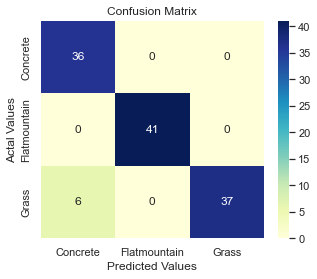

Epoch: 32, Loss: 0.03, Accuracy on training set is: 99.38
Finished Training
Epoch: 32, Loss: 0.26, Accuracy on testing set is: 89.17


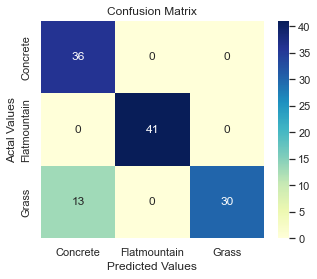

Epoch: 33, Loss: 0.02, Accuracy on training set is: 99.17
Finished Training
Epoch: 33, Loss: 0.14, Accuracy on testing set is: 95.00


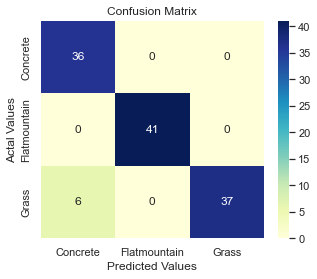

Epoch: 34, Loss: 0.02, Accuracy on training set is: 99.79
Finished Training
Epoch: 34, Loss: 0.15, Accuracy on testing set is: 94.17


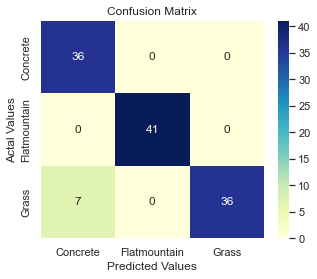

Epoch: 35, Loss: 0.02, Accuracy on training set is: 99.79
Finished Training
Epoch: 35, Loss: 0.10, Accuracy on testing set is: 97.50


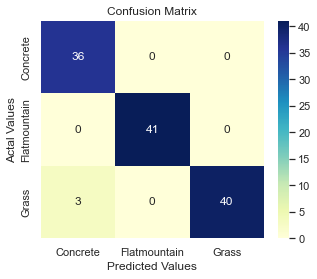

Epoch: 36, Loss: 0.02, Accuracy on training set is: 99.58
Finished Training
Epoch: 36, Loss: 0.15, Accuracy on testing set is: 94.17


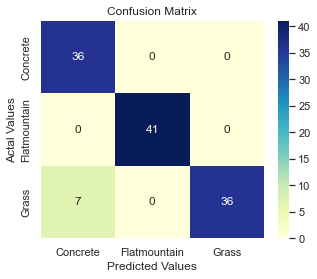

Epoch: 37, Loss: 0.02, Accuracy on training set is: 99.79
Finished Training
Epoch: 37, Loss: 0.13, Accuracy on testing set is: 95.00


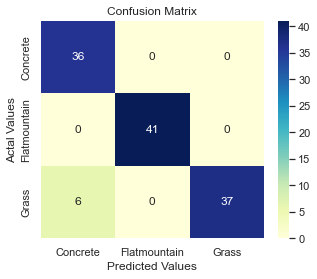

Epoch: 38, Loss: 0.02, Accuracy on training set is: 99.58
Finished Training
Epoch: 38, Loss: 0.13, Accuracy on testing set is: 96.67


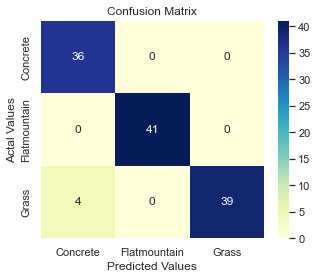

Epoch: 39, Loss: 0.02, Accuracy on training set is: 99.17
Finished Training
Epoch: 39, Loss: 0.09, Accuracy on testing set is: 97.50


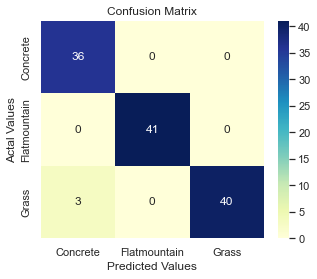

Epoch: 40, Loss: 0.01, Accuracy on training set is: 99.79
Finished Training
Epoch: 40, Loss: 0.18, Accuracy on testing set is: 95.00


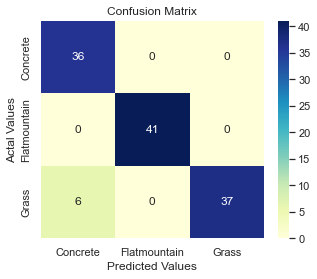

Epoch: 41, Loss: 0.02, Accuracy on training set is: 99.38
Finished Training
Epoch: 41, Loss: 0.13, Accuracy on testing set is: 95.83


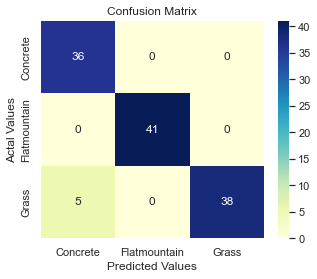

Epoch: 42, Loss: 0.02, Accuracy on training set is: 98.96
Finished Training
Epoch: 42, Loss: 0.11, Accuracy on testing set is: 95.83


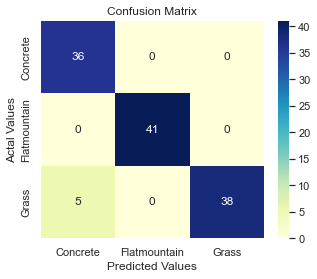

Epoch: 43, Loss: 0.03, Accuracy on training set is: 99.38
Finished Training
Epoch: 43, Loss: 0.17, Accuracy on testing set is: 94.17


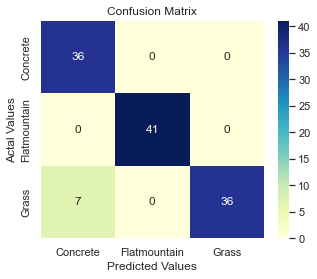

Epoch: 44, Loss: 0.02, Accuracy on training set is: 99.58
Finished Training
Epoch: 44, Loss: 0.12, Accuracy on testing set is: 96.67


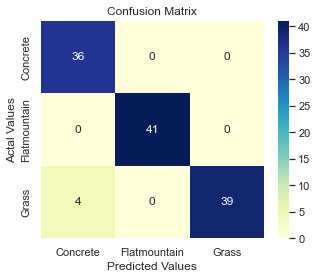

Epoch: 45, Loss: 0.02, Accuracy on training set is: 99.58
Finished Training
Epoch: 45, Loss: 0.14, Accuracy on testing set is: 95.83


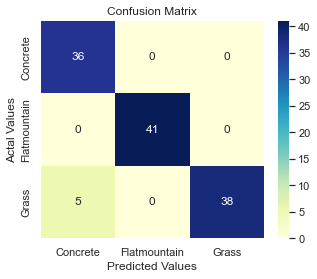

Epoch: 46, Loss: 0.02, Accuracy on training set is: 99.79
Finished Training
Epoch: 46, Loss: 0.16, Accuracy on testing set is: 92.50


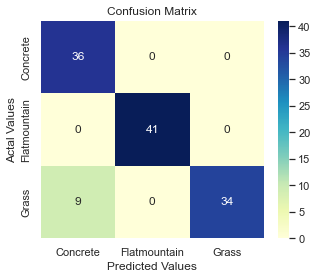

Epoch: 47, Loss: 0.02, Accuracy on training set is: 99.38
Finished Training
Epoch: 47, Loss: 0.18, Accuracy on testing set is: 95.00


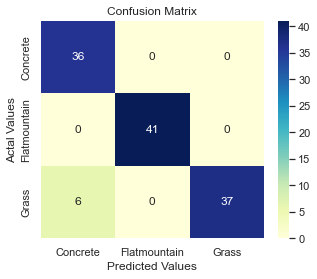

Epoch: 48, Loss: 0.02, Accuracy on training set is: 99.58
Finished Training
Epoch: 48, Loss: 0.16, Accuracy on testing set is: 94.17


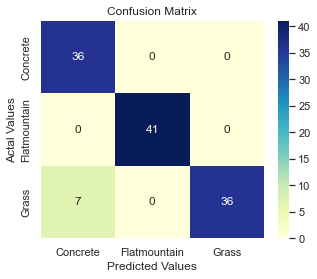

Epoch: 49, Loss: 0.01, Accuracy on training set is: 100.00
Finished Training
Epoch: 49, Loss: 0.18, Accuracy on testing set is: 92.50


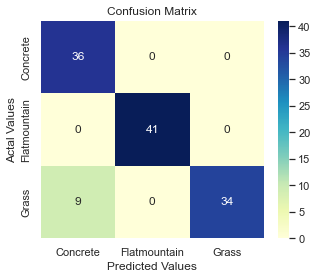

In [25]:
test_accu = []
train_accu= []
train_losses =[]
test_losses =[]
for epoch in range(num_epochs):
    train(model,train_loader,optimizer,scheduler)
    test(model,test_loader)

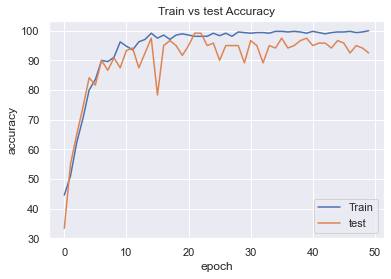

In [26]:
plt.plot(train_accu)
plt.plot(test_accu,)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','test'])
plt.title('Train vs test Accuracy')

plt.show()

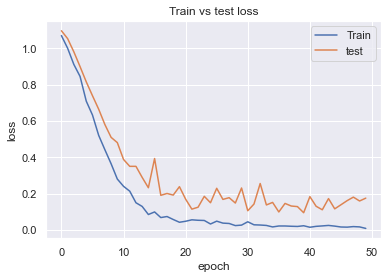

In [27]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','test'])
plt.title('Train vs test loss')

plt.show()

In [28]:
test_accuarcy = 0.0
for samples, labels in test_loader:
    with torch.no_grad():
        samples, labels = samples, labels
        inputs_m, inputs_s = samples.mean(), samples.std()
        samples = (samples - inputs_m) / inputs_s
        output = model(samples)
        # calculate accuracy
        pred = torch.argmax(output, dim=1)
        correct = pred.eq(labels)
        test_accuarcy += torch.mean(correct.float())
print('Accuracy of the network on {} test images: {}%'.format(len(val_ds), round(test_accuarcy.item()*100.0/len(test_loader), 2)))


Accuracy of the network on 120 test images: 94.53%


In [29]:
# prepare to count predictions for each class
classes = ('Concrete', 'Flatmountain', 'Grass')

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}


# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        samples, labels = samples, labels
        inputs_m, inputs_s = samples.mean(), samples.std()
        samples = (samples - inputs_m) / inputs_s
        outputs = model(samples)
        _, predictions = torch.max(outputs, 1)
        #collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

            

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: Concrete is 100.0 %
Accuracy for class: Flatmountain is 100.0 %
Accuracy for class: Grass is 100.0 %


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.000s...
[t-SNE] Computed neighbors for 120 samples in 0.016s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 1.174361
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.568970
[t-SNE] KL divergence after 1000 iterations: 0.033604


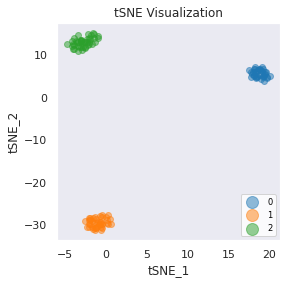

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.000s...
[t-SNE] Computed neighbors for 120 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 1.223301
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.178284
[t-SNE] KL divergence after 1000 iterations: 0.045930


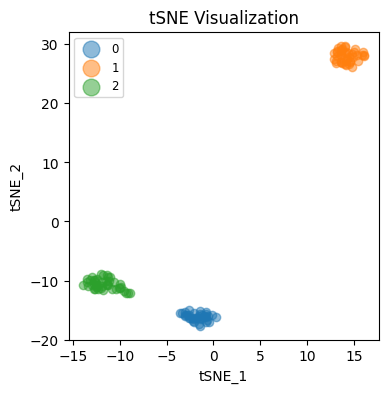

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.000s...
[t-SNE] Computed neighbors for 120 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 1.232534
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.392395
[t-SNE] KL divergence after 1000 iterations: 0.057049


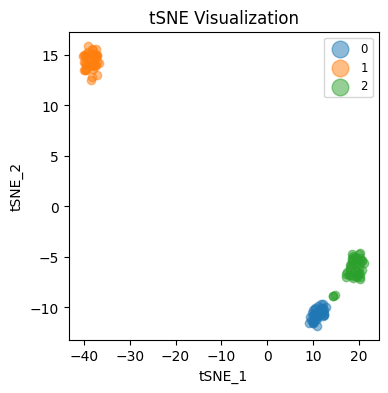

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.000s...
[t-SNE] Computed neighbors for 120 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 1.139774
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.472107
[t-SNE] KL divergence after 950 iterations: 0.035154


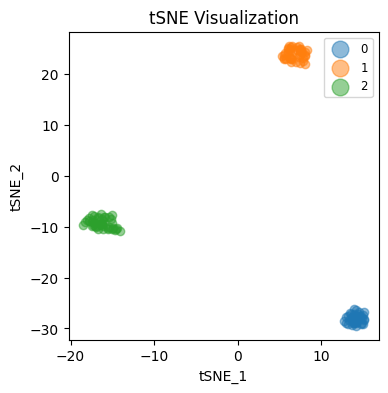

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.000s...
[t-SNE] Computed neighbors for 120 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 1.223754
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.323837
[t-SNE] KL divergence after 1000 iterations: 0.041843


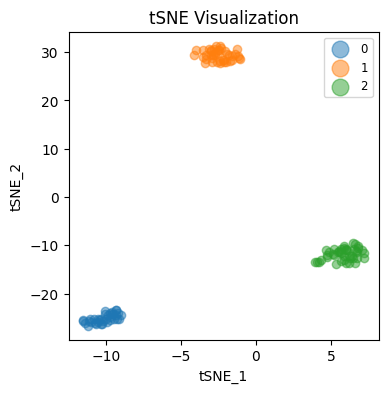

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.000s...
[t-SNE] Computed neighbors for 120 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 1.190986
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.411453
[t-SNE] KL divergence after 1000 iterations: 0.044903


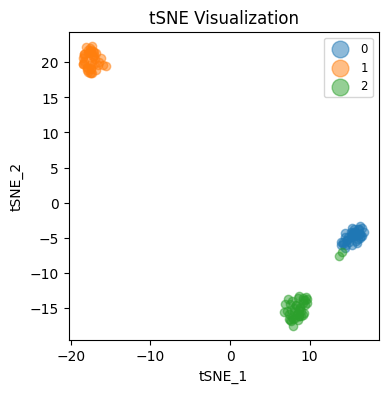

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.000s...
[t-SNE] Computed neighbors for 120 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 1.188449
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.634033
[t-SNE] KL divergence after 1000 iterations: 0.057016


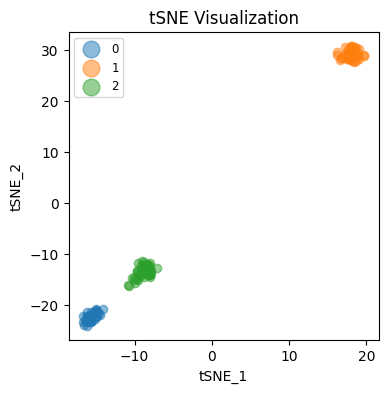

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.000s...
[t-SNE] Computed neighbors for 120 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 1.225884
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.556145
[t-SNE] KL divergence after 1000 iterations: 0.055473


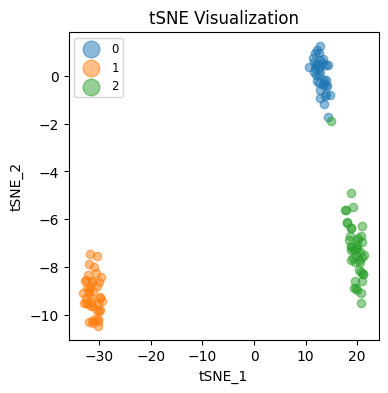

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.000s...
[t-SNE] Computed neighbors for 120 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 1.159212
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.101151
[t-SNE] KL divergence after 1000 iterations: 0.053660


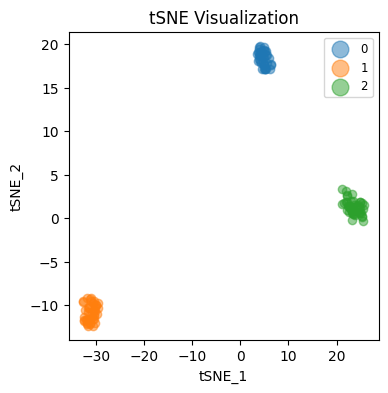

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.000s...
[t-SNE] Computed neighbors for 120 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 1.277936
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.964405
[t-SNE] KL divergence after 1000 iterations: 0.051331


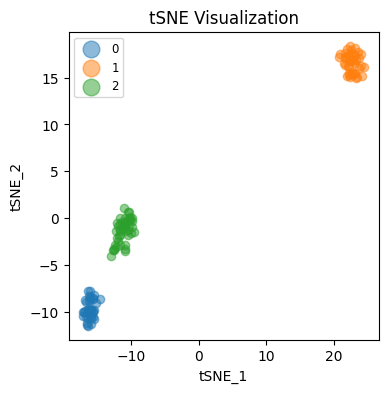

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.000s...
[t-SNE] Computed neighbors for 120 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 1.203224
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.179688
[t-SNE] KL divergence after 1000 iterations: 0.032465


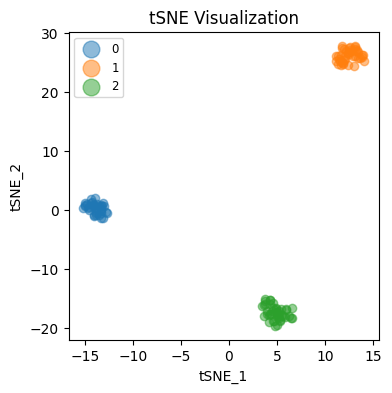

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.000s...
[t-SNE] Computed neighbors for 120 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 1.175262
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.076885
[t-SNE] KL divergence after 1000 iterations: 0.048475


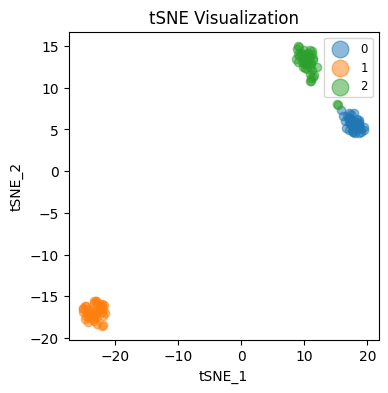

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.000s...
[t-SNE] Computed neighbors for 120 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 1.218816
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.072701
[t-SNE] KL divergence after 1000 iterations: 0.037232


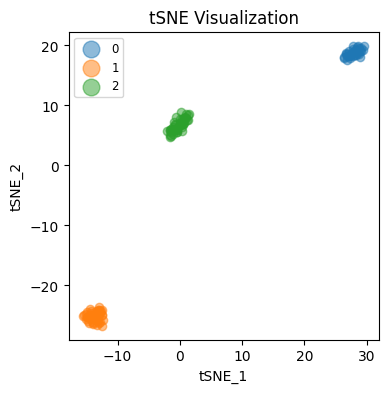

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.000s...
[t-SNE] Computed neighbors for 120 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 1.210293
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.385002
[t-SNE] KL divergence after 1000 iterations: 0.049467


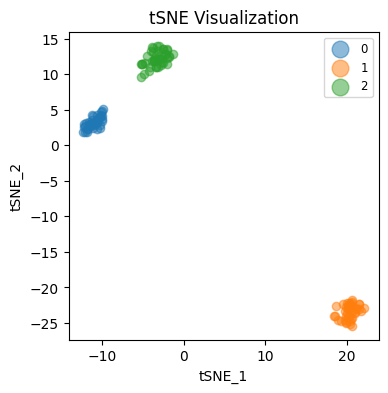

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.000s...
[t-SNE] Computed neighbors for 120 samples in 0.016s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 1.151568
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.723995
[t-SNE] KL divergence after 1000 iterations: 0.030233


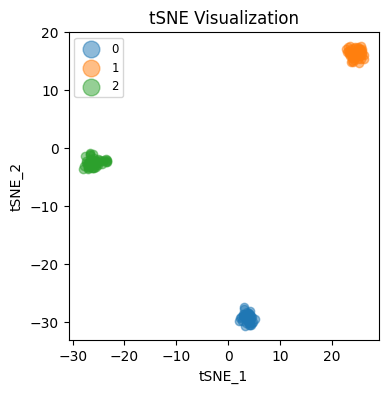

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.000s...
[t-SNE] Computed neighbors for 120 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 1.220527
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.366665
[t-SNE] KL divergence after 1000 iterations: 0.050064


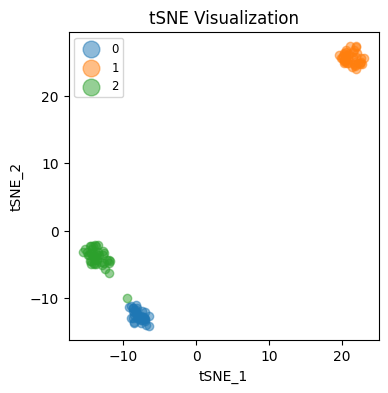

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.000s...
[t-SNE] Computed neighbors for 120 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 1.209690
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.433758
[t-SNE] KL divergence after 1000 iterations: 0.052577


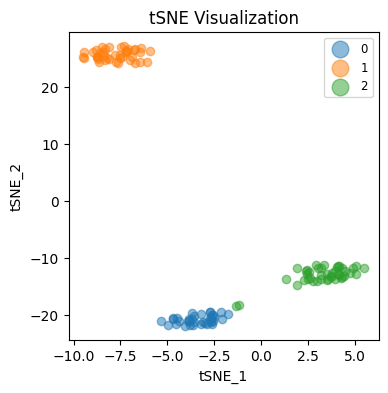

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.000s...
[t-SNE] Computed neighbors for 120 samples in 0.016s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 1.251849
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.756042
[t-SNE] KL divergence after 1000 iterations: 0.056867


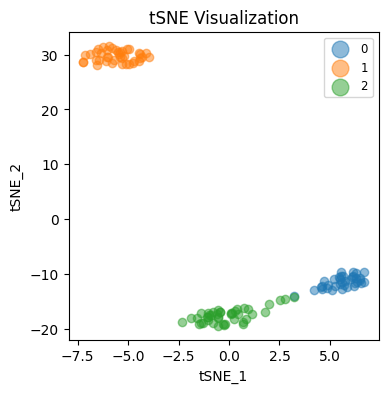

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.000s...
[t-SNE] Computed neighbors for 120 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 1.192058
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.481323
[t-SNE] KL divergence after 1000 iterations: 0.051505


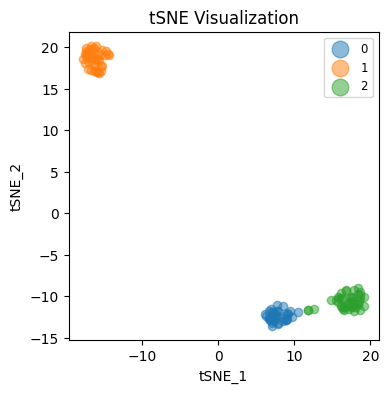

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.000s...
[t-SNE] Computed neighbors for 120 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 1.210445
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.886070
[t-SNE] KL divergence after 1000 iterations: 0.041368


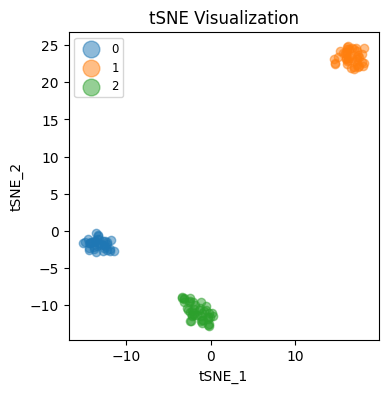

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.000s...
[t-SNE] Computed neighbors for 120 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 1.218950
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.502876
[t-SNE] KL divergence after 1000 iterations: 0.043458


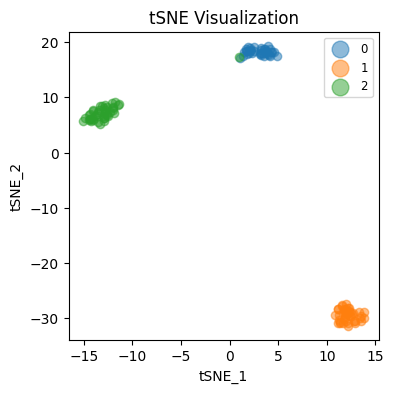

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.000s...
[t-SNE] Computed neighbors for 120 samples in 0.016s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 1.241853
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.584282
[t-SNE] KL divergence after 1000 iterations: 0.051856


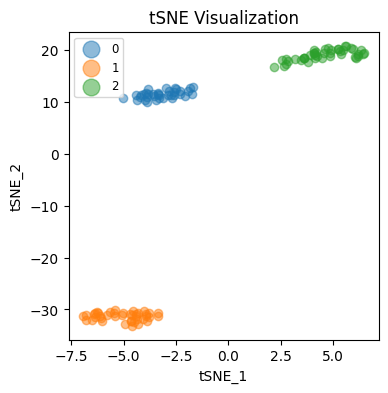

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.000s...
[t-SNE] Computed neighbors for 120 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 1.222082
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.164021
[t-SNE] KL divergence after 1000 iterations: 0.045801


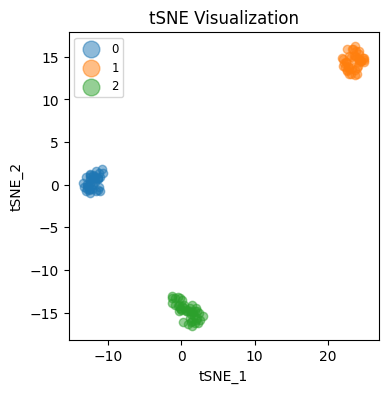

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.000s...
[t-SNE] Computed neighbors for 120 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 1.223036
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.450607
[t-SNE] KL divergence after 1000 iterations: 0.053400


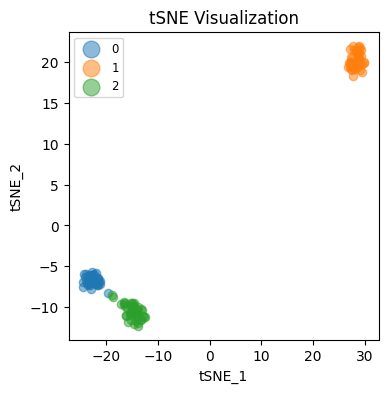

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.000s...
[t-SNE] Computed neighbors for 120 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 1.220883
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.957954
[t-SNE] KL divergence after 1000 iterations: 0.053517


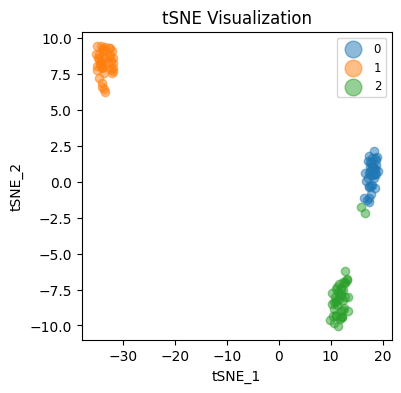

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.000s...
[t-SNE] Computed neighbors for 120 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 1.131000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.511139
[t-SNE] KL divergence after 1000 iterations: 0.038186


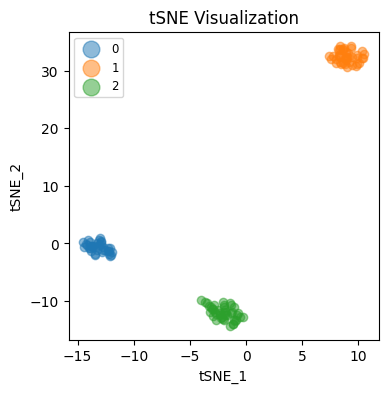

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.000s...
[t-SNE] Computed neighbors for 120 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 1.220601
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.531609
[t-SNE] KL divergence after 1000 iterations: 0.049507


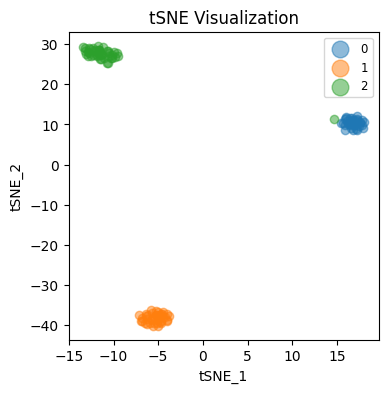

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.000s...
[t-SNE] Computed neighbors for 120 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 1.248548
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.810944
[t-SNE] KL divergence after 1000 iterations: 0.067229


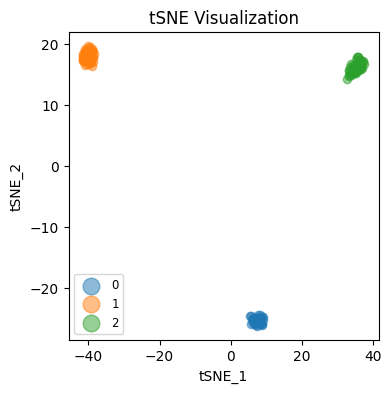

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.000s...
[t-SNE] Computed neighbors for 120 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 1.266457
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.782898
[t-SNE] KL divergence after 1000 iterations: 0.042729


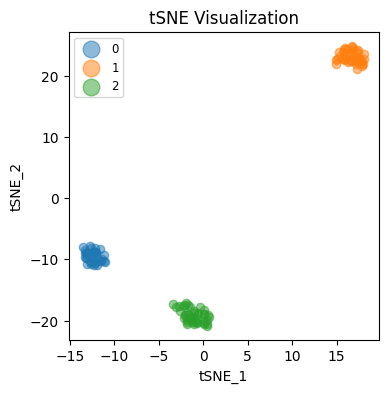

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.000s...
[t-SNE] Computed neighbors for 120 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 1.203504
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.862236
[t-SNE] KL divergence after 1000 iterations: 0.029930


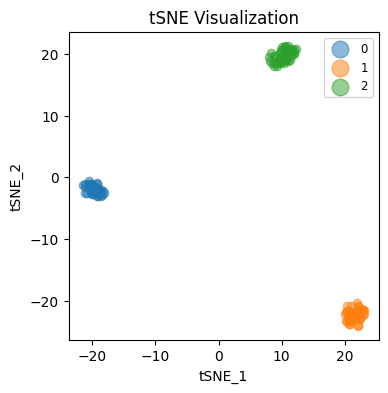

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.000s...
[t-SNE] Computed neighbors for 120 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 1.271734
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.115360
[t-SNE] KL divergence after 1000 iterations: 0.043002


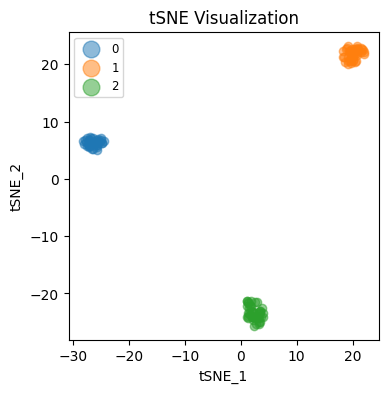

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.000s...
[t-SNE] Computed neighbors for 120 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 1.269864
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.439751
[t-SNE] KL divergence after 1000 iterations: 0.047486


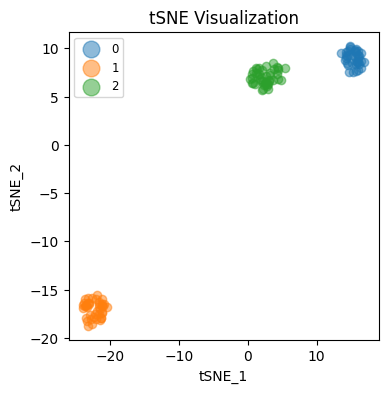

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.000s...
[t-SNE] Computed neighbors for 120 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 1.191792
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.421440
[t-SNE] KL divergence after 1000 iterations: 0.037142


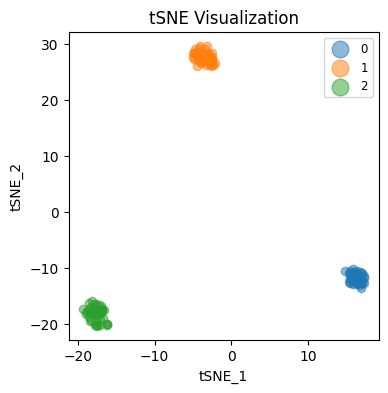

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.000s...
[t-SNE] Computed neighbors for 120 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 1.230884
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.049774
[t-SNE] KL divergence after 1000 iterations: 0.048302


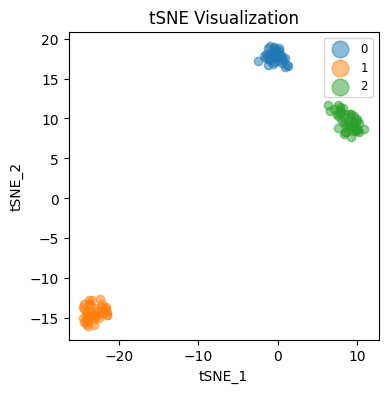

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.000s...
[t-SNE] Computed neighbors for 120 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 1.123303
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.673073
[t-SNE] KL divergence after 1000 iterations: 0.049485


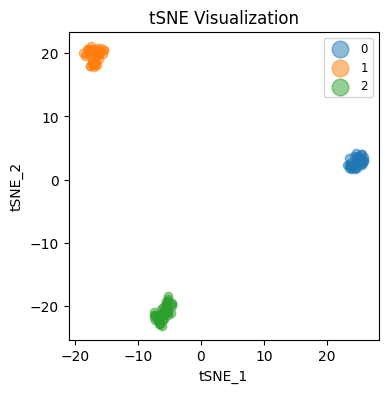

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.000s...
[t-SNE] Computed neighbors for 120 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 1.234543
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.451534
[t-SNE] KL divergence after 1000 iterations: 0.064467


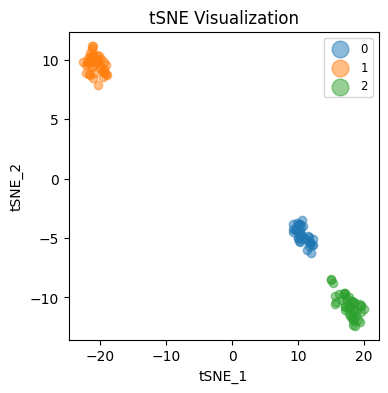

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.000s...
[t-SNE] Computed neighbors for 120 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 1.244202
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.071575
[t-SNE] KL divergence after 1000 iterations: 0.048776


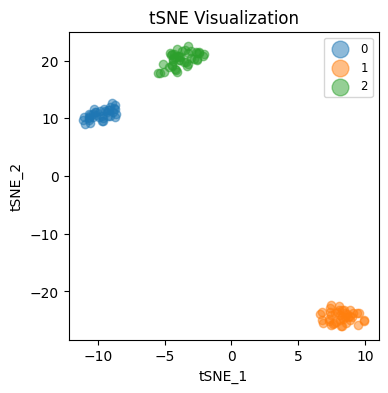

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.000s...
[t-SNE] Computed neighbors for 120 samples in 0.016s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 1.164740
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.203487
[t-SNE] KL divergence after 1000 iterations: 0.043065


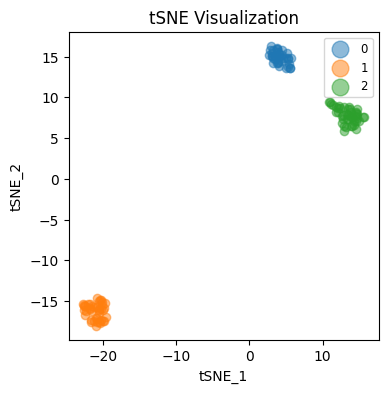

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.000s...
[t-SNE] Computed neighbors for 120 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 1.202162
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.317059
[t-SNE] KL divergence after 1000 iterations: 0.031210


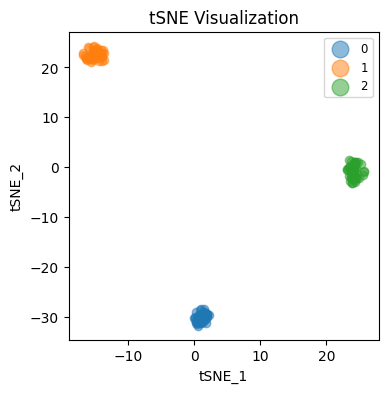

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.000s...
[t-SNE] Computed neighbors for 120 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 1.201685
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.984200
[t-SNE] KL divergence after 1000 iterations: 0.054111


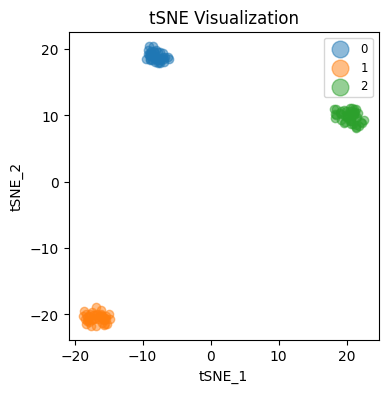

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.000s...
[t-SNE] Computed neighbors for 120 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 1.259698
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.454456
[t-SNE] KL divergence after 1000 iterations: 0.044045


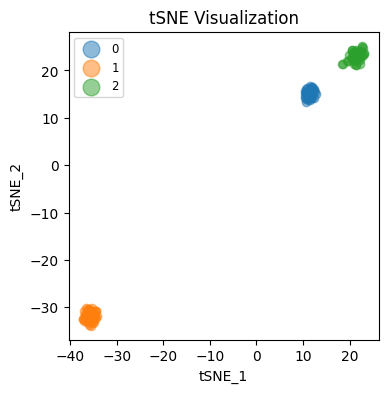

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.000s...
[t-SNE] Computed neighbors for 120 samples in 0.016s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 1.173821
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.879158
[t-SNE] KL divergence after 1000 iterations: 0.038237


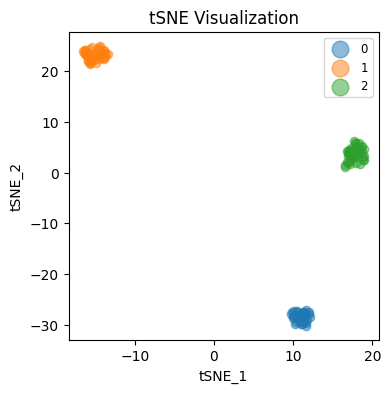

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.004s...
[t-SNE] Computed neighbors for 120 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 1.234727
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.772820
[t-SNE] KL divergence after 1000 iterations: 0.047535


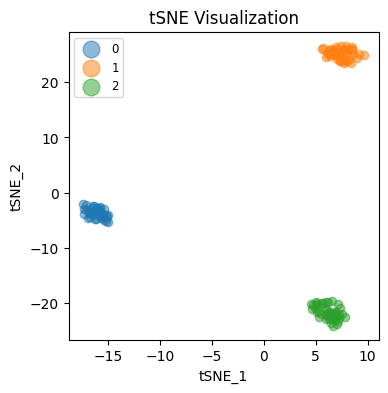

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.000s...
[t-SNE] Computed neighbors for 120 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 1.204422
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.614597
[t-SNE] KL divergence after 1000 iterations: 0.052198


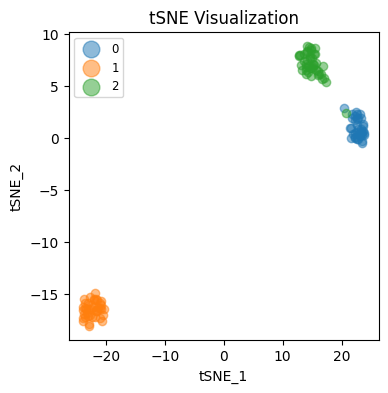

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.000s...
[t-SNE] Computed neighbors for 120 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 1.172081
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.745758
[t-SNE] KL divergence after 1000 iterations: 0.039805


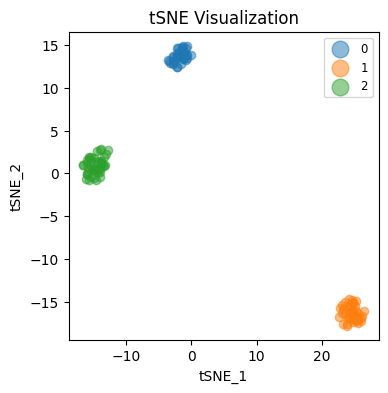

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.000s...
[t-SNE] Computed neighbors for 120 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 1.231015
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.132927
[t-SNE] KL divergence after 1000 iterations: 0.046868


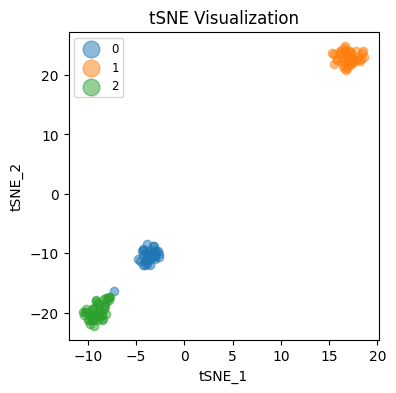

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.000s...
[t-SNE] Computed neighbors for 120 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 1.134582
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.609421
[t-SNE] KL divergence after 1000 iterations: 0.027002


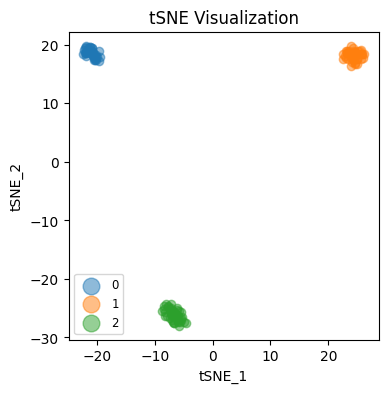

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.000s...
[t-SNE] Computed neighbors for 120 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 1.139109
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.071701
[t-SNE] KL divergence after 800 iterations: 0.056917


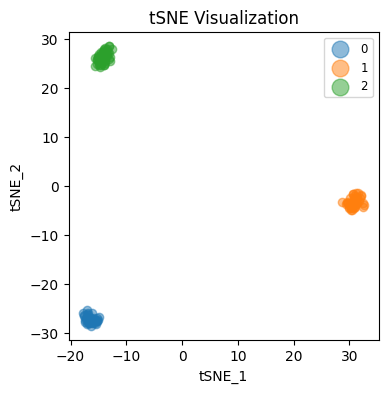

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.000s...
[t-SNE] Computed neighbors for 120 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 1.159831
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.568504
[t-SNE] KL divergence after 800 iterations: 0.037056


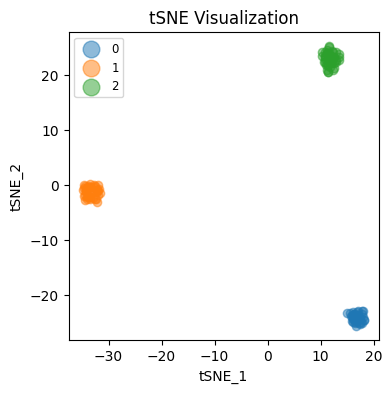

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 120 samples in 0.000s...
[t-SNE] Computed neighbors for 120 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 120 / 120
[t-SNE] Mean sigma: 1.163708
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.237232
[t-SNE] KL divergence after 1000 iterations: 0.043713


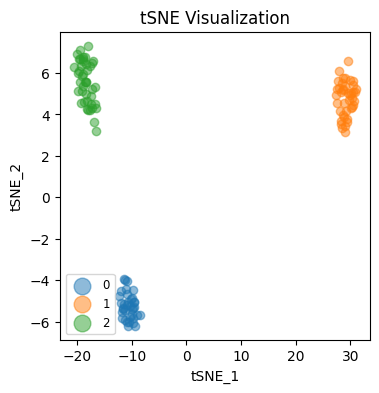

In [30]:
#visualize the ouput layer for the test data 

def test2(model, test_loader):
        model.eval()
        test_targets = []
        #test_embeddings = torch.zeros((32), dtype=torch.float32)
        test_embeddings = []
        
        
        with torch.no_grad():
            for x,y in test_loader:
    
                logits =y
                inputs_m, inputs_s = x.mean(), x.std()
                x = (x - inputs_m) / inputs_s
    
                embeddings= model(x)
    
                test_targets.extend(y.detach().cpu().tolist())
                test_embeddings.extend(embeddings.detach().cpu().tolist())
                #test_embeddings = torch.cat((test_embeddings, embeddings.detach().cpu()), 0)


        test_embeddings = np.array(test_embeddings)
        test_targets = np.array(test_targets)
        
        tsne = TSNE(n_components=2, verbose=1, learning_rate= 300, init = 'random')
        tsne_proj = tsne.fit_transform(test_embeddings)#.reshape(1,-1))

        
        cmap = cm.get_cmap('tab10')
        fig, ax = plt.subplots(figsize=(4,4))
        ax.set_title('tSNE Visualization')
        ax.set_xlabel('tSNE_1') 
        ax.set_ylabel('tSNE_2')
  
        ax.grid(False)
        #ax.axis('off')
        mpl.style.use('default')
        num_categories = 3
        for lab in range(num_categories):
            indices = test_targets==lab
            ax.scatter(x=tsne_proj[indices,0],y=tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
        ax.legend(fontsize='small', markerscale=2)
        plt.show()
        




for epoch in range(num_epochs):
    test2(model,test_loader)

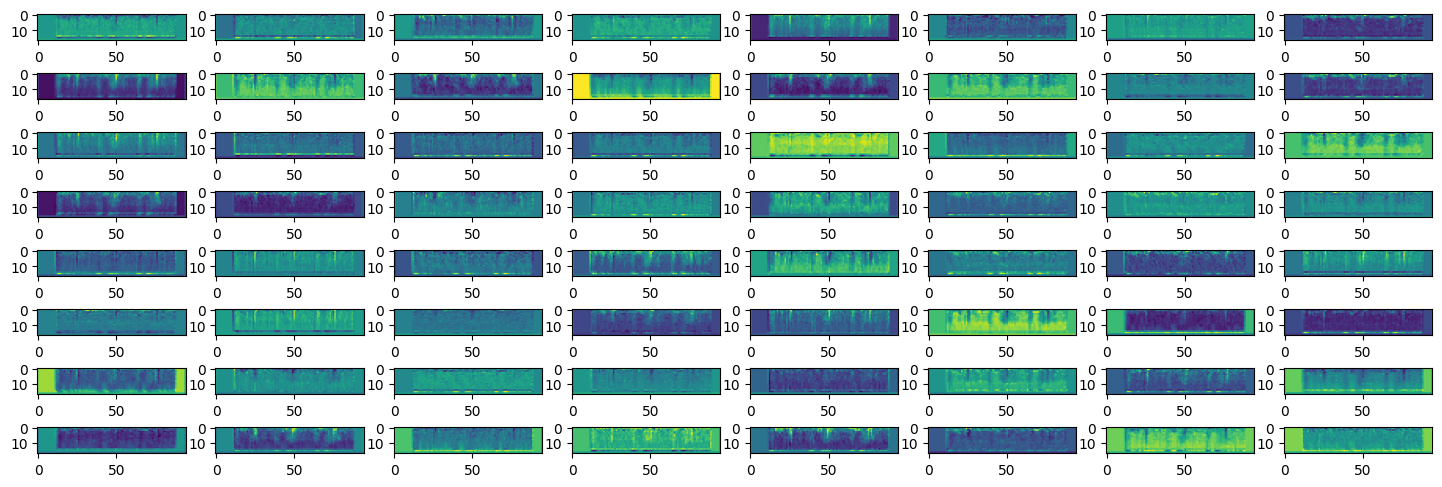

In [31]:
# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.conv2.register_forward_hook(get_activation('conv2'))
data= train_loader.dataset[0][0]
data.unsqueeze_(0)
inputs_m, inputs_s = data.mean(), data.std()
data = (data - inputs_m) / inputs_s
        
output = model(data)

act = activation['conv2'].squeeze()
    
    

fig, axarr = plt.subplots(nrows=8, ncols=8, figsize=(18, 6))

k = 0
for idx in range(act.size(0)//8):
    for idy in range(act.size(0)//8):
        axarr[idx, idy].imshow(act[k])
        k += 1